In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import librosa as lb
import IPython.display as ipd
import librosa.display
import soundfile as sf
import os

# Part 1 - Exploratory Data Analysis

In [5]:
def getFilenameInfo(file):
    return file.split('_')

,Cycle start,Cycle end,Crackles,Wheezes
0,0.036,0.579,0,0
1,0.579,2.450,0,0
2,2.450,3.893,0,0
3,3.893,5.793,0,0
4,5.793,7.521,0,0


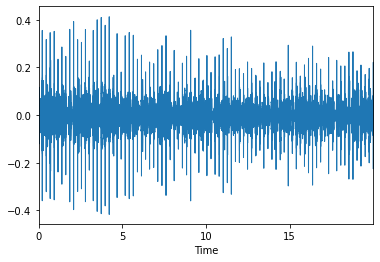

In [3]:
filename = 'Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav'
data,sample_rate = librosa.load(filename)
librosa.display.waveplot(data, sr=sample_rate)

respiratory_data=pd.read_csv('Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt', sep='\t', names=['Cycle start', 'Cycle end', 'Crackles', 'Wheezes'])
respiratory_data.head(5)

In [6]:
## Extract filenames from all .txt files
path='Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

## From this we're going to extract PID and audio acquisition mode (sc/mc)
getFilenameInfo(files[0])

['101', '1b1', 'Al', 'sc', 'Meditron']

In [7]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron


In [8]:
patient_data = pd.read_csv('Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['pid', 'disease'])

In [9]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [10]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI


In [17]:
# Save data
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

# Part 2 - Processing Audio files

In [18]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and splits it using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

<AxesSubplot:ylabel='pid'>

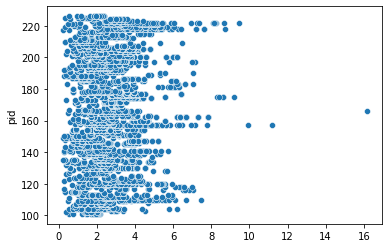

In [19]:
# We want our audio files to be of the same length.
# Plotting the length of all audio files.
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<AxesSubplot:>

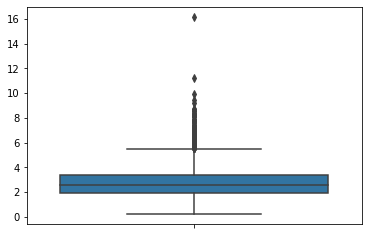

In [20]:
# From this plot we can conclude with that the average cycle length is ~6
sns.boxplot(y=(data.end-data.start))

In [21]:
# Creating a directory for the processed files
os.makedirs('processed_audio_files')

In [24]:
import librosa as lb
import soundfile as sf
i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

Total Files Processed:  6898


In [12]:
def extractId(filename):
    return filename.split('_')[0]

In [13]:
length = len(os.listdir('processed_audio_files/'))
index = range(length)

# We will now create a new dataframe with the class corresponding to the pid for each of the processed_audio_files.
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])

for f in os.listdir('processed_audio_files/'):
    files_df.iloc[i]['pid'] = extractId(f)
    files_df.iloc[i]['filename'] = f
    i+=1

files_df.head()

diagnosis=pd.read_csv('Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv',names=['pid','disease'])

files_df.pid=files_df.pid.astype('int64') # both pid's must be of same dtype for them to merge
data=pd.merge(files_df,diagnosis,on='pid')
data.groupby('disease').count()

NameError: name 'extractID' is not defined

In [36]:
from sklearn.model_selection import train_test_split

# Now we have the training and test set.
X_train, X_test, y_train, y_test = train_test_split(data, data.disease, stratify=data.disease, test_size=0.25)
